In [71]:
import os
import json
from typing import List, Literal, Optional, Text, Union, Dict, Any
from IPython.display import Image, display
from langchain_core.runnables.graph_mermaid import MermaidDrawMethod
from agents.agents_modules.workflow import build_agent_workflow
from agents.dataloader import load_dataset_by_name, extract_example
from agents.utilities.agent_utils import save_result_to_json
from agents.llm_model import UnifiedModel, model_name
from agents.agent_prompts import END_TO_END_GENERATION_PROMPT, input_prompt, CONTENT_SELECTION_PROMPT

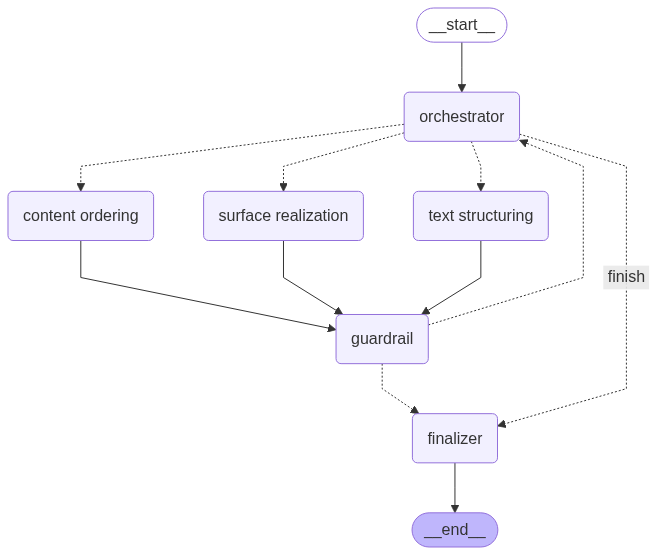

In [72]:
provider = "openai" #ollama, openai, hf, aixplain
process_flow = build_agent_workflow(provider=provider)
display(Image(process_flow.get_graph(xray=True).draw_mermaid_png()))

In [73]:
# Exclude turku_hockey and conversational_weather
# totto, webnlg, dart, rotowire, sportsett_basketball, mlb
name = "dart"  
num = 5000 # Sample id
set = "test"

data = load_dataset_by_name(name)
dataset = data[set]
sample = extract_example(name, data[set][num])
data = sample.get('input', '')
ground_truth = sample.get('references', "")
target = sample.get('target', "")

print(f"Size: {len(dataset)}")
print("========== INPUT DATA ==========")
print(f"{data}\n")
print("========== TARGET (if any) ==========")
print(f"{target}\n")
print("========== GROUND TRUTH REFERENCES ==========")
print(f"{ground_truth}")

Loading dataset: dart
Size: 5097
========== INPUT DATA ==========
[['The Wrestlers', 'eatType', 'restaurant'], ['The Wrestlers', 'food', 'Italian'], ['The Wrestlers', 'priceRange', 'moderate'], ['The Wrestlers', 'area', 'riverside'], ['The Wrestlers', 'familyFriendly', 'yes']]

========== TARGET (if any) ==========
The Wrestlers is a moderately priced Italian restaurant that is kids friendly near Raja located in riverside.

========== GROUND TRUTH REFERENCES ==========
['The Wrestlers is a moderately priced Italian restaurant that is kids friendly near Raja located in riverside.']


In [74]:
conf = model_name.get(provider.lower())
llm = UnifiedModel(provider=provider, **conf).model_(CONTENT_SELECTION_PROMPT)
prediction = llm.invoke({'input': data}).content.strip()
print(prediction)

[
  "Name: The Wrestlers",
  "Eat Type (The Wrestlers): restaurant",
  "Food (The Wrestlers): Italian",
  "Price Range (The Wrestlers): moderate",
  "Area (The Wrestlers): riverside",
  "Family Friendly (The Wrestlers): yes"
]


In [75]:
query = f"""You are an agent designed to generate text from data for a data-to-text natural language generation. You can be provided data in the form of xml, table, meaning representations, graphs etc. 
Your task is to generate the appropriate text given the data information without omitting any field or adding extra information in essence called hallucination.
Here is the data generate text using table data:
{prediction}"""

initial_state = {
    "user_prompt": query,
    "raw_data": data,
    "history_of_steps": [],
    "final_response": "",
    "next_agent": "",
    "next_agent_payload": "",
    "current_step": 0,
    "iteration_count": 0,
    "max_iteration": 100,
}

state = process_flow.invoke(initial_state, config={"recursion_limit": initial_state["max_iteration"]})
prediction = state['final_response']



> Entering new AgentExecutor chain...
{
  "action": "Final Answer",
  "action_input": [
    "Name: The Wrestlers",
    "Eat Type (The Wrestlers): restaurant",
    "Area (The Wrestlers): riverside",
    "Food (The Wrestlers): Italian",
    "Price Range (The Wrestlers): moderate",
    "Family Friendly (The Wrestlers): yes"
  ]
}

> Finished chain.


> Entering new AgentExecutor chain...
{
  "action": "Final Answer",
  "action_input": "<paragraph>\n<snt>\nName: The Wrestlers\nEat Type (The Wrestlers): restaurant\n</snt>\n<snt>\nArea (The Wrestlers): riverside\n</snt>\n<snt>\nFood (The Wrestlers): Italian\nPrice Range (The Wrestlers): moderate\nFamily Friendly (The Wrestlers): yes\n</snt>\n</paragraph>"
}

> Finished chain.


> Entering new AgentExecutor chain...
{
  "action": "Final Answer",
  "action_input": "The Wrestlers is a restaurant located by the riverside, offering a family-friendly atmosphere. This establishment specializes in Italian cuisine and is known for its moderate pric

In [76]:
# state["history_of_steps"]

In [77]:
# print(state["history_of_steps"][-1].agent_input)

In [78]:
save_result_to_json(state, filename=f"{name}_{num}_new.json")
# save_result_to_json(state, filename=f"webnlg_long.json")

Results saved to results/dart_5000_new.json


In [79]:
print(prediction)

The Wrestlers is a restaurant located by the riverside, offering a family-friendly atmosphere. This establishment specializes in Italian cuisine and is known for its moderate pricing, making it an appealing choice for diners seeking both quality and affordability.


In [80]:
ground_truth

['The Wrestlers is a moderately priced Italian restaurant that is kids friendly near Raja located in riverside.']

In [81]:
target

'The Wrestlers is a moderately priced Italian restaurant that is kids friendly near Raja located in riverside.'

In [82]:
# from agents.evaluator import evaluate_single

# scores = evaluate_single(target, prediction, data)
# for metric, score in scores.items():
#     print(f"{metric}: {score:.4f}")

In [83]:
# data = """[['Lagos', 'areaLand', '999600000.0'],
#  ['Lagos', 'areaMetro', '2706700000.0'],
#  ['Lagos', 'areaUrban', '907000000.0'],
#  ['Lagos', 'populationMetro', '21320000'],
#  ['Lagos', 'populationMetroDensity', '7759.0'],
#  ['Lagos', 'areaMetro', '2706.7'],
#  ['Lagos', 'areaTotal', '1171.28'],
#  ['Lagos', 'areaUrban', '907.0'],
#  ['Lagos', 'populationDensity', '6871.0'],
#  ['Lagos', 'populationMetroDensity', '7759.0'],
#  ['Lagos', 'areaCode', '010'],
#  ['Lagos', 'areaTotal', '1171280000.0'],
#  ['Lagos', 'demonym', 'Lagosian'],
#  ['Lagos', 'motto', 'Èkó ò ní bàjé o!'],
#  ['Lagos', 'populationDensity', '6871.0'],
#  ['Lagos', 'populationTotal', '8048430'],
#  ['Lagos', 'utcOffset', '+1'],
#  ['Lagos', 'country', 'Nigeria'],
#  ['Lagos', 'founder', 'Awori_tribe'],
#  ['Lagos', 'timeZone', 'West_Africa_Time'],
#  ['Benfruit_Plant', 'location', 'Lagos'],
#  ['Nigerian_Institute_of_Management', 'location', 'Lagos'],
#  ['Before_30', 'location', 'Lagos'],
#  ['Reduction_of_Lagos', 'place', 'Lagos'],
#  ["Cait_O'Riordan", 'birthPlace', 'Lagos'],
#  ['Candy_Augustine_Agbane', 'birthPlace', 'Lagos'],
#  ['Carol_King_(actress)', 'birthPlace', 'Lagos'],
#  ['Amusa_Shittu', 'deathPlace', 'Lagos'],
#  ['Samuel_Ajayi_Crowther', 'deathPlace', 'Lagos'],
#  ['Samuel_Johnson_(Nigerian_historian)', 'deathPlace', 'Lagos'],
#  ['Dobox', 'foundationPlace', 'Lagos'],
#  ['IROKO_Partners', 'foundationPlace', 'Lagos'],
#  ['Isaac_Fola-Alade', 'significantBuilding', 'Lagos'],
#  ['Olufemi_Majekodunmi', 'significantBuilding', 'Lagos'],
#  ['Cally_Air', 'targetAirport', 'Lagos'],
#  ['Ibom_Air', 'targetAirport', 'Lagos'],
#  ['Max_Air', 'targetAirport', 'Lagos'],
#  ['Isaac_Fola-Alade', 'significantProject', 'Lagos'],
#  ['ADC_Airlines', 'hubAirport', 'Lagos'],
#  ['Babington_Macaulay_Junior_Seminary', 'state', 'Lagos'],
#  ['Government_College_Ikorodu', 'state', 'Lagos'],
#  ['Ebun_Oluwa_Pro_Veritas', 'state', 'Lagos'],
#  ['Colonial_Nigeria', 'capital', 'Lagos'],
#  ['Federation_of_Nigeria', 'capital', 'Lagos'],
#  ['Lagos_Colony', 'capital', 'Lagos'],
#  ['African_Union', 'largestCity', 'Lagos'],
#  ['Nigeria', 'largestCity', 'Lagos'],
#  ['Military_dictatorship_in_Nigeria', 'largestCity', 'Lagos'],
#  ['Volkswagen_Beetle', 'assembly', 'Lagos'],
#  ['Volkswagen_Jetta_(A2)', 'assembly', 'Lagos'],
#  ['Isuzu_Forward', 'assembly', 'Lagos'],
#  ['Juliet_Ibrahim', 'award', 'Lagos'],
#  ['Benin-Ore-Shagamu_Expressway', 'city', 'Lagos'],
#  ['Encomium_Magazine', 'city', 'Lagos'],
#  ['Bogobiri_House', 'city', 'Lagos'],
#  ['Sub-Saharan_Africa', 'country', 'Lagos'],
#  ['Desmond_Majekodunmi', 'education', 'Lagos'],
#  ['Buchi_Emecheta', 'education', 'Lagos'],
#  ['Habeeb_Okunola', 'education', 'Lagos'],
#  ['MFM_F.C.', 'ground', 'Lagos'],
#  ['ACB_Lagos_F.C.', 'ground', 'Lagos'],
#  ['COD_United_F.C.', 'ground', 'Lagos'],
#  ['Caritas_Communications', 'headquarter', 'Lagos'],
#  ['Nigerian_Accounting_Association', 'headquarter', 'Lagos'],
#  ['Merchant_Express_Aviation', 'headquarter', 'Lagos'],
#  ['Sasha_P', 'hometown', 'Lagos'],
#  ['Davina_Oriakhi', 'hometown', 'Lagos'],
#  ['VanJess', 'hometown', 'Lagos'],
#  ['Olu_Amoda', 'knownFor', 'Lagos'],
#  ['Toki_Mabogunje', 'knownFor', 'Lagos'],
#  ['United_Africa_Company_of_Nigeria', 'locationCity', 'Lagos'],
#  ['Promasidor_Nigeria', 'locationCity', 'Lagos'],
#  ['G-Worldwide_Entertainment', 'locationCity', 'Lagos'],
#  ['LADOL', 'locationCountry', 'Lagos'],
#  ['Atlantic_Ocean', 'nearestCity', 'Lagos'],
#  ['Lagos_Lagoon', 'nearestCity', 'Lagos'],
#  ['Let_Me_Roll_It', 'recordedIn', 'Lagos'],
#  ['Mamunia', 'recordedIn', 'Lagos'],
#  ['Band_on_the_Run_(song)', 'recordedIn', 'Lagos'],
#  ['First_Consultant_Hospital', 'region', 'Lagos'],
#  ['National_Orthopaedic_Hospital,_Igbobi', 'region', 'Lagos'],
#  ['GIG_Mobility', 'regionServed', 'Lagos'],
#  ['TEDxLagos', 'regionServed', 'Lagos'],
#  ['Patrick_Utomi', 'residence', 'Lagos'],
#  ['Dakuku_Peterside', 'residence', 'Lagos'],
#  ['Mudashiru_Obasa', 'residence', 'Lagos']]"""

In [84]:
lagos_86 = """Lagos is located in Nigeria, and its inhabitants are known as Lagosians. The city's motto is 'Èkó ò ní bàjé o!' and it was founded by the Awori tribe. Lagos operates on West Africa Time, with a UTC offset of +1. The land area of Lagos covers 999.6 square kilometers, with the urban area measuring 907 square kilometers, while the metropolitan area spans 2,706.7 square kilometers. The total area of the city is 1,171.28 square kilometers. Lagos has a population of 8,048,430, with a population density of 6,871 people per square kilometer, while the metropolitan population reaches 21,320,000 with a metro density of 7,759 per square kilometer. The city's area code is 010.

The Atlantic Ocean and Lagos Lagoon are closest to Lagos. It is recognized as the largest city within the African Union, Nigeria, and during the Military dictatorship in Nigeria. Lagos has also served as the capital of Colonial Nigeria, the Federation of Nigeria, and the Lagos Colony. In Sub-Saharan Africa, Lagos is counted among its prominent cities.

Numerous institutions and organizations are based in Lagos, such as Benfruit Plant, the Nigerian Institute of Management, and Before 30. The city is also the foundation place of Dobox and IROKO Partners. Companies like Caritas Communications, the Nigerian Accounting Association, and Merchant Express Aviation have their headquarters in Lagos. The United Africa Company of Nigeria, Promasidor Nigeria, and G-Worldwide Entertainment are all located in the city. LADOL is also situated in Lagos. Lagos serves as the region for GIG Mobility and TEDxLagos, as well as for First Consultant Hospital and National Orthopaedic Hospital, Igbobi. Notable locations like the Benin-Ore-Shagamu Expressway, Encomium Magazine, and Bogobiri House are found here, and educational institutions such as Babington Macaulay Junior Seminary, Government College Ikorodu, and Ebun Oluwa Pro Veritas are located within Lagos State. Lagos is home to the grounds of MFM F.C., ACB Lagos F.C., and COD United F.C., and is associated with the assembly of vehicles like the Volkswagen Beetle, Volkswagen Jetta (A2), and Isuzu Forward. The city is known for significant buildings designed by Isaac Fola-Alade and Olufemi Majekodunmi, as well as a significant project by Isaac Fola-Alade. Music recordings such as 'Let Me Roll It', 'Mamunia', and 'Band on the Run' were recorded in Lagos. The city is notable for the historic Reduction of Lagos, and features as a target airport for airlines including Cally Air, Ibom Air, and Max Air, while also serving as a hub for ADC Airlines.

Lagos is the hometown of personalities such as Sasha P, Davina Oriakhi, and VanJess. It is likewise the birthplace of Cait O'Riordan, Candy Augustine Agbane, and Carol King the actress. The city is where figures like Amusa Shittu, Samuel Ajayi Crowther, and Samuel Johnson, the Nigerian historian, passed away. It is home to residents including Patrick Utomi, Dakuku Peterside, and Mudashiru Obasa. Individuals such as Olu Amoda and Toki Mabogunje are known for their connections to Lagos. The city is where Desmond Majekodunmi, Buchi Emecheta, and Habeeb Okunola received their education, and Juliet Ibrahim is among those who have received awards in Lagos."""

print(lagos_86)

Lagos is located in Nigeria, and its inhabitants are known as Lagosians. The city's motto is 'Èkó ò ní bàjé o!' and it was founded by the Awori tribe. Lagos operates on West Africa Time, with a UTC offset of +1. The land area of Lagos covers 999.6 square kilometers, with the urban area measuring 907 square kilometers, while the metropolitan area spans 2,706.7 square kilometers. The total area of the city is 1,171.28 square kilometers. Lagos has a population of 8,048,430, with a population density of 6,871 people per square kilometer, while the metropolitan population reaches 21,320,000 with a metro density of 7,759 per square kilometer. The city's area code is 010.

The Atlantic Ocean and Lagos Lagoon are closest to Lagos. It is recognized as the largest city within the African Union, Nigeria, and during the Military dictatorship in Nigeria. Lagos has also served as the capital of Colonial Nigeria, the Federation of Nigeria, and the Lagos Colony. In Sub-Saharan Africa, Lagos is counted